In [1]:
# Imports and environment setup
import os,sys,importlib,gc,pickle
import cartopy.io.shapereader as shapereader
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.ops import cascaded_union

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cartopy
import cartopy.crs as ccrs

import xarray as xr
import numpy as np

import pandas as pd

os.chdir('/home/peter/Projects/tc_emulator/results/')

label='ibtracks'

In [2]:
tracks_raw = pd.read_csv('/home/peter/Projects/data/ibtracs.NA.list.v04r00.csv', sep=',', low_memory=False)
units = tracks_raw.iloc[0]
#print(units)
tracks_raw = tracks_raw.drop([0])
print(list(tracks_raw.columns))
tracks_raw.head()

['SID', 'SEASON', 'NUMBER', 'BASIN', 'SUBBASIN', 'NAME', 'ISO_TIME', 'NATURE', 'LAT', 'LON', 'WMO_WIND', 'WMO_PRES', 'WMO_AGENCY', 'TRACK_TYPE', 'DIST2LAND', 'LANDFALL', 'IFLAG', 'USA_AGENCY', 'USA_ATCF_ID', 'USA_LAT', 'USA_LON', 'USA_RECORD', 'USA_STATUS', 'USA_WIND', 'USA_PRES', 'USA_SSHS', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW', 'USA_POCI', 'USA_ROCI', 'USA_RMW', 'USA_EYE', 'TOKYO_LAT', 'TOKYO_LON', 'TOKYO_GRADE', 'TOKYO_WIND', 'TOKYO_PRES', 'TOKYO_R50_DIR', 'TOKYO_R50_LONG', 'TOKYO_R50_SHORT', 'TOKYO_R30_DIR', 'TOKYO_R30_LONG', 'TOKYO_R30_SHORT', 'TOKYO_LAND', 'CMA_LAT', 'CMA_LON', 'CMA_CAT', 'CMA_WIND', 'CMA_PRES', 'HKO_LAT', 'HKO_LON', 'HKO_CAT', 'HKO_WIND', 'HKO_PRES', 'NEWDELHI_LAT', 'NEWDELHI_LON', 'NEWDELHI_GRADE', 'NEWDELHI_WIND', 'NEWDELHI_PRES', 'NEWDELHI_CI', 'NEWDELHI_DP', 'NEWDELHI_POCI', 'REUNION_LAT', 'REUNION_LON', 'REUNION_TYPE', 'REUNION_W

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
1,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 12:00:00,TS,26.1000,-90.4000,...,,,,,,,,,6,291
2,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 15:00:00,TS,26.2001,-90.6999,...,,,,,,,,,6,290
3,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 18:00:00,TS,26.3000,-91.0000,...,,,,,,,,,6,290
4,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-23 21:00:00,TS,26.3999,-91.3001,...,,,,,,,,,6,290
5,1851175N26270,1851,5,NaN,GM,NOT_NAMED,1851-06-24 00:00:00,TS,26.5000,-91.6000,...,,,,,,,,,6,290


In [3]:
np.unique(tracks_raw['NATURE'])

array(['DS', 'ET', 'MX', 'NR', 'SS', 'TS'], dtype=object)

In [4]:
tracks_raw["ISO_TIME"] = pd.to_datetime(tracks_raw["ISO_TIME"]) 
notna1 = (tracks_raw['ISO_TIME'].dt.year >= 1982) & (tracks_raw['ISO_TIME'].dt.year <= 2022)
tracks_raw["WMO_WIND"] = tracks_raw["WMO_WIND"].replace(' ',np.nan)
tracks_raw["WMO_WIND"] = pd.to_numeric(tracks_raw["WMO_WIND"]) 
notna2 = np.isfinite(tracks_raw['WMO_WIND'].values) & (tracks_raw['WMO_WIND'] > 0)
notna3 = tracks_raw['NATURE'] == 'TS'
notna = notna1 & notna2 & notna3

In [5]:
tracks_raw = tracks_raw[notna].reset_index()
tracks_raw.head()

,index,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,88100,1982154N22273,1982,33,NaN,GM,ALBERTO,1982-06-02 12:00:00,TS,21.7000,...,,,,,,,,,7,47
1,88102,1982154N22273,1982,33,NaN,GM,ALBERTO,1982-06-02 18:00:00,TS,22.2000,...,,,,,,,,,8,52
2,88104,1982154N22273,1982,33,NaN,GM,ALBERTO,1982-06-03 00:00:00,TS,22.6000,...,,,,,,,,,8,68
3,88106,1982154N22273,1982,33,NaN,GM,ALBERTO,1982-06-03 06:00:00,TS,22.8000,...,,,,,,,,,8,71
4,88108,1982154N22273,1982,33,NaN,GM,ALBERTO,1982-06-03 12:00:00,TS,23.2000,...,,,,,,,,,9,47


In [6]:
for var in ['LAT','LON','DIST2LAND']:
    tracks_raw[var] = pd.to_numeric(tracks_raw[var]) 

In [7]:
ace = tracks_raw['WMO_WIND'].values.copy()
ace[ace < 34] = 0
ace = ace ** 2 / 10000
tracks_raw['ACE'] = ace

In [8]:
tracks_raw['SID'] = np.repeat(np.array([float(sid.replace('N','.')) for sid in tracks_raw['SID'].values])[:,np.newaxis], 360, 1)
tracks_raw['daily_identifier'] = np.array(np.array([str(tt)[:10] for tt in tracks_raw['ISO_TIME']], np.datetime64) \
                                          - np.datetime64('1970-01-01'), float) \
                                          + tracks_raw['SID'] * 10**9

In [9]:
tracks_raw = tracks_raw[['daily_identifier','NAME','ACE','SID','WMO_WIND','LAT','LON','ISO_TIME','DIST2LAND']]

In [10]:
tracks = tracks_raw.groupby('daily_identifier').mean()
tracks['name'] = tracks_raw.groupby('daily_identifier').first()['NAME']

tracks['time'] = tracks_raw.groupby('daily_identifier').first()['ISO_TIME']
# open an example file to get the time axis
nc_example = xr.open_dataset('/home/peter/Projects/data/ERA5/ERA5_vws_atl_1x1_daily_rmTC.nc')
hour_stamp = int(str(nc_example.time.values[0])[11:13])
tracks['time'] = np.array(["%d-%02d-%02dT%02d:00:00" % (t.year,t.month,t.day,hour_stamp) for t in tracks['time']], np.datetime64)
tracks['year'] = tracks['time'].dt.year
tracks['month'] = tracks['time'].dt.month
tracks['day'] = tracks['time'].dt.day

tracks['storm'] = tracks_raw.groupby('daily_identifier').first()['SID']
tracks['storm_day'] = 0
for storm in np.unique(tracks['storm']):
	tmp = tracks.loc[tracks.storm==storm,'storm_day']
	tracks.loc[tracks.storm==storm,'storm_day'] = np.arange(len(tmp))+1

tracks['lat'] = tracks_raw.groupby('daily_identifier').mean()['LAT']
tracks['lon'] = tracks_raw.groupby('daily_identifier').mean()['LON']
tracks['distance'] = tracks_raw.groupby('daily_identifier').mean()['DIST2LAND']

tracks['ACE'] = tracks_raw.groupby('daily_identifier').sum()['ACE']

tracks['wind'] = tracks_raw.groupby('daily_identifier').max()['WMO_WIND']
tracks = tracks.reset_index()
tracks['wind_before'] = 0
for i in tracks.index.values[1:]:
	if tracks.storm[i] == tracks.storm[i-1]:
		tracks.loc[tracks.index==i,'wind_before'] = tracks.wind[i-1]
genesis = np.concatenate(([1], np.diff(tracks['storm'],1)))
genesis[genesis > 0] = 1
tracks['genesis'] = genesis
tracks.head()

,daily_identifier,ACE,SID,WMO_WIND,LAT,LON,DIST2LAND,name,time,year,month,day,storm,storm_day,lat,lon,distance,wind,wind_before,genesis
0,1.982154e+15,0.0000,1.982154e+06,22.500000,21.95,-86.800000,57.500000,ALBERTO,1982-06-02,1982,6,2,1.982154e+06,1,21.95,-86.800000,57.500000,25.0,0,1.0
1,1.982154e+15,0.9725,1.982154e+06,48.750000,23.15,-84.650000,94.750000,ALBERTO,1982-06-03,1982,6,3,1.982154e+06,2,23.15,-84.650000,94.750000,75.0,25,0.0
2,1.982154e+15,1.0875,1.982154e+06,51.250000,24.90,-84.125000,237.500000,ALBERTO,1982-06-04,1982,6,4,1.982154e+06,3,24.90,-84.125000,237.500000,65.0,75,0.0
3,1.982154e+15,0.0000,1.982154e+06,26.250000,25.25,-83.900000,230.250000,ALBERTO,1982-06-05,1982,6,5,1.982154e+06,4,25.25,-83.900000,230.250000,30.0,65,0.0
4,1.982154e+15,0.0000,1.982154e+06,23.333333,25.50,-82.966667,133.666667,ALBERTO,1982-06-06,1982,6,6,1.982154e+06,5,25.50,-82.966667,133.666667,25.0,30,0.0


In [11]:
tracks[tracks.name == 'IRMA']

,daily_identifier,ACE,SID,WMO_WIND,LAT,LON,DIST2LAND,name,time,year,month,day,storm,storm_day,lat,lon,distance,wind,wind_before,genesis
3339,2.017242e+15,0.5750,2.017242e+06,40.000000,16.225000,-28.925000,1236.000000,IRMA,2017-08-30,2017,8,30,2.017242e+06,1,16.225000,-28.925000,1236.000000,50.0,0,1.0
3340,2.017242e+15,2.2675,2.017242e+06,73.750000,16.625000,-32.950000,1667.750000,IRMA,2017-08-31,2017,8,31,2.017242e+06,2,16.625000,-32.950000,1667.750000,95.0,50,0.0
3341,2.017242e+15,4.0000,2.017242e+06,100.000000,18.150000,-36.750000,2047.750000,IRMA,2017-09-01,2017,9,1,2.017242e+06,3,18.150000,-36.750000,2047.750000,100.0,95,0.0
3342,2.017242e+15,3.8050,2.017242e+06,97.500000,18.950000,-41.875000,1931.000000,IRMA,2017-09-02,2017,9,2,2.017242e+06,4,18.950000,-41.875000,1931.000000,100.0,100,0.0
3343,2.017242e+15,3.8050,2.017242e+06,97.500000,18.050000,-47.325000,1548.000000,IRMA,2017-09-03,2017,9,3,2.017242e+06,5,18.050000,-47.325000,1548.000000,100.0,100,0.0
3344,2.017242e+15,4.6350,2.017242e+06,107.500000,16.950000,-52.100000,1184.750000,IRMA,2017-09-04,2017,9,4,2.017242e+06,6,16.950000,-52.100000,1184.750000,115.0,100,0.0
3345,2.017242e+15,8.0375,2.017242e+06,141.250000,16.700000,-57.125000,798.250000,IRMA,2017-09-05,2017,9,5,2.017242e+06,7,16.700000,-57.125000,798.250000,155.0,115,0.0
3346,2.017242e+15,16.6650,2.017242e+06,154.285714,18.000000,-62.828571,295.714286,IRMA,2017-09-06,2017,9,6,2.017242e+06,8,18.000000,-62.828571,295.714286,155.0,155,0.0
3347,2.017242e+15,8.5575,2.017242e+06,146.250000,19.950000,-68.300000,109.750000,IRMA,2017-09-07,2017,9,7,2.017242e+06,9,19.950000,-68.300000,109.750000,150.0,155,0.0
3348,2.017242e+15,9.3875,2.017242e+06,137.000000,21.580000,-73.740000,82.000000,IRMA,2017-09-08,2017,9,8,2.017242e+06,10,21.580000,-73.740000,82.000000,140.0,150,0.0


In [12]:
tracks = tracks[np.isin(tracks.time.dt.month,[8,9,10])].reset_index()

In [13]:
tracks.to_csv('tracks/tracks_'+label+'.csv')

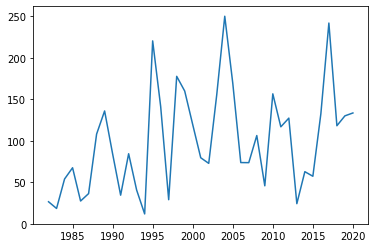

In [14]:
year = np.unique(tracks['year'])
plt.plot(year, tracks.groupby('year').sum()['ACE'])

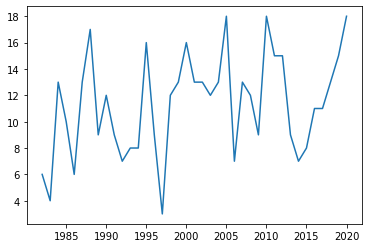

In [15]:
plt.plot(year, tracks.groupby('year').sum()['genesis'])